In [193]:
%matplotlib inline
import pandas as pd
from glob import glob
import sys
import json
import os
import numpy as np
import re
import matplotlib.pyplot as plt
import seaborn as sns
from autoexperiment.template import generate_job_defs
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.max_colwidth', None)

def get_samples_per_sec(path):
    all_vals = []
    data = open(path).readlines()
    for line in data:
        if "Train Epoch" in line:
            vals = re.findall("\d+\.\d*\/s,", line)
            vals = [float(v.replace("/s,", "")) for v in vals]
            all_vals.extend(vals)
    return np.mean(all_vals[1:])
def human(v):
    if v < 10 ** 6:
        return str(v)
    elif v > 10**6 and v < 10**9:
        return (str(v/10**6)+"M").replace(".0M", "M")
    elif v > 10**9:
        return (str(v/10**9)+"B").replace(".0B", "B")


def load_results(folder):
    paths = glob(os.path.join(folder, "*.json"))
    results = []
    for path in paths:
        if 'latest' in path:
            continue
        data = json.load(open(path))
        dic = {}
        dic.update(data['metrics'])
        dic['epoch'] = int(re.search(r"epoch\_([0-9]+).pt", path).groups(1)[0]) 
        dic['dataset'] = os.path.basename(path).split("_")[0]
        results.append(dic)
    return pd.DataFrame(results)

In [158]:
model_profile = pd.read_csv("https://raw.githubusercontent.com/mlfoundations/open_clip/main/docs/model_profile.csv")
model_profile  = model_profile.set_index("model")

In [164]:

jobs = generate_job_defs("config_cosine_lr.yaml")
train_jobs = [job for job in jobs if job.params['mode'] == 'train']
results = []
for job in train_jobs:
    folder = os.path.dirname(job.output_file)
    paths = glob(os.path.join(folder, "checkpoints", "*.json"))
    samples_per_sec = get_samples_per_sec(job.output_file) if os.path.exists(job.output_file) else None
    for path in paths:
        data = json.load(open(path))
        dic = {
            'model': job.params['model'],
            "pretrain_dataset": job.params['dataset'],
            "downstream_dataset": data['dataset'],
            'epoch': int(re.search(r"epoch\_([0-9]+).pt", path).groups(1)[0]),
            "total_epochs": int(job.params["epochs"]),
            "name": job.params["name"],
            "gflops_total": model_profile.loc[job.params["model"]].gflops * int(job.params["epochs"]) * job.params["train_num_samples"],
            "samples_per_sec": samples_per_sec,
            "samples_per_sec_per_gpu": samples_per_sec / (job.params["nodes"] * 4),
            "global_batch_size": job.params["batch_size"] * job.params["nodes"] * 4,
            "training_time_hours": ((1/samples_per_sec) * int(job.params["epochs"]) * job.params["train_num_samples"]) / 3600,
            "gpus": job.params["nodes"] * 4,
            "total_steps": (int(job.params["epochs"]) * job.params["train_num_samples"]) // (job.params["batch_size"] * job.params["nodes"] * 4)
        }
        dic["gpu_hours"] = dic["gpus"] * dic["training_time_hours"]
        dic.update(job.params)
        dic.update(data['metrics'])
        results.append(dic)
cosine_lr_results = pd.DataFrame(results)



jobs = generate_job_defs("config_const_lr.yaml")
train_jobs = [job for job in jobs if job.params['mode'] == 'train']
train_jobs = [job for job in train_jobs if job.params['phase'] == 'pretrain']
results = []
for job in train_jobs:
    folder = os.path.dirname(job.output_file)
    paths = glob(os.path.join(folder, "checkpoints", "*.json"))
    samples_per_sec = get_samples_per_sec(job.output_file) if os.path.exists(job.output_file) else None
    for path in paths:
        data = json.load(open(path))
        total_epochs =  int(job.params["max_epochs"])
        epoch =  int(re.search(r"epoch\_([0-9]+).pt", path).groups(1)[0])
        dic = {
            'model': job.params['model'],
            "pretrain_dataset": job.params['dataset'],
            "downstream_dataset": data['dataset'],
            'epoch': epoch,
            "total_epochs": total_epochs,
            "name": job.params["name"],
            "gflops_total": model_profile.loc[job.params["model"]].gflops * epoch * job.params["train_num_samples"],
            "samples_per_sec": samples_per_sec,
            "samples_per_sec_per_gpu": samples_per_sec / (job.params["nodes"] * 4),
            "global_batch_size": job.params["batch_size"] * job.params["nodes"] * 4,
            "training_time_hours": ((1/samples_per_sec) * epoch * job.params["train_num_samples"]) / 3600,
            "gpus": job.params["nodes"] * 4,
            "total_steps": ((epoch) * job.params["train_num_samples"]) // (job.params["batch_size"] * job.params["nodes"] * 4),
            "samples_seen_scale": human(epoch * job.params["train_num_samples"]),
        }
        dic["gpu_hours"] = dic["gpus"] * dic["training_time_hours"]
        dic.update(job.params)
        dic.update(data['metrics'])
        results.append(dic)
const_lr_results_pretrain = pd.DataFrame(results)





jobs = generate_job_defs("config_const_lr.yaml")
train_jobs = [job for job in jobs if job.params['mode'] == 'train']
train_jobs = [job for job in train_jobs if job.params['phase'] == 'cooldown']
results = []
for job in train_jobs:
    folder = os.path.dirname(job.output_file)
    paths = glob(os.path.join(folder, "checkpoints", "*.json"))
    samples_per_sec = get_samples_per_sec(job.output_file) if os.path.exists(job.output_file) else None
    for path in paths:
        data = json.load(open(path))
        last_epoch = int(job.params["cooldown_checkpoint"]) + int(job.params["epochs_cooldown"])
        total_epochs =  int(job.params["epochs_cooldown"])
        dic = {
            'model': job.params['model'],
            "pretrain_dataset": job.params['dataset'],
            "downstream_dataset": data['dataset'],
            'epoch': int(re.search(r"epoch\_([0-9]+).pt", path).groups(1)[0]),
            "total_epochs": last_epoch,
            "name": job.params["name"],
            "gflops_total": model_profile.loc[job.params["model"]].gflops *total_epochs * job.params["train_num_samples"],
            "samples_per_sec": samples_per_sec,
            "samples_per_sec_per_gpu": samples_per_sec / (job.params["nodes"] * 4),
            "global_batch_size": job.params["batch_size"] * job.params["nodes"] * 4,
            "training_time_hours": ((1/samples_per_sec) * total_epochs * job.params["train_num_samples"]) / 3600,
            "gpus": job.params["nodes"] * 4,
            "total_steps": ((total_epochs) * job.params["train_num_samples"]) // (job.params["batch_size"] * job.params["nodes"] * 4)
        }
        dic["gpu_hours"] = dic["gpus"] * dic["training_time_hours"]
        dic.update(job.params)
        dic.update(data['metrics'])
        results.append(dic)
const_lr_results_cooldown = pd.DataFrame(results)


jobs = generate_job_defs("config_cosine_lr_periodic.yaml")
train_jobs = [job for job in jobs if job.params['mode'] == 'train']

results = []
for job in train_jobs:
    folder = os.path.dirname(job.output_file)
    paths = glob(os.path.join(folder, "checkpoints", "*.json"))
    samples_per_sec = get_samples_per_sec(job.output_file) if os.path.exists(job.output_file) else None
    for path in paths:
        data = json.load(open(path))
        epoch = int(re.search(r"epoch\_([0-9]+).pt", path).groups(1)[0])
        dic = {
            'model': job.params['model'],
            "pretrain_dataset": job.params['dataset'],
            "downstream_dataset": data['dataset'],
            'epoch': epoch,
            "total_epochs": epoch,
            "name": job.params["name"],
            "gflops_total": model_profile.loc[job.params["model"]].gflops * epoch * job.params["train_num_samples"],
            "samples_per_sec": samples_per_sec,
            "samples_per_sec_per_gpu": samples_per_sec / (job.params["nodes"] * 4),
            "global_batch_size": job.params["batch_size"] * job.params["nodes"] * 4,
            "training_time_hours": ((1/samples_per_sec) * total_epochs * job.params["train_num_samples"]) / 3600,
            "gpus": job.params["nodes"] * 4,
            "total_steps": ((total_epochs) * job.params["train_num_samples"]) // (job.params["batch_size"] * job.params["nodes"] * 4),
            "samples_seen_scale": human(epoch * job.params["train_num_samples"]),

        }
        dic["gpu_hours"] = dic["gpus"] * dic["training_time_hours"]
        dic.update(job.params)
        dic.update(data['metrics'])
        results.append(dic)
cosine_lr_periodic_results = pd.DataFrame(results)


/p/project/ccstdl/laion/mamba/envs/experimental-torch-nightly/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/p/project/ccstdl/laion/mamba/envs/experimental-torch-nightly/lib/python3.10/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


In [220]:
results = cosine_lr_periodic_results
results

,model,pretrain_dataset,downstream_dataset,epoch,total_epochs,name,gflops_total,samples_per_sec,samples_per_sec_per_gpu,global_batch_size,training_time_hours,gpus,total_steps,samples_seen_scale,gpu_hours,job_id_regexp,cmd,check_interval_secs,partition,account,beta1,beta2,wd,time_minutes,grad_clip_norm,logs,pretrained,nodes,train_num_samples,lr,batch_size,siglip,max_epochs,warmup,lr_scheduler,cosine_period_total_samples,lr_cooldown_end,lr_cooldown_power,epochs_cooldown,folder_name,epochs,resume,mode,train,template,sbatch_script,output_file,termination_cmd,dataset,datacomp,train_data,exp_name,acc1,acc5,mean_per_class_recall,image_retrieval_recall@5,text_retrieval_recall@5
0,ViT-B-32,datacomp,wds/imagenet1k,12,12,datacomp_ViT-B-32_ep100_lr0.001_b1_0.9_b2_0.95_wd0.2_w500_gc1_n64_bs354_sigFalse_period128000000_train,2.270208e+10,211237.223858,825.145406,90624,4.208013,256,35310,1.536B,1077.251213,Job Id:(\d+),sbatch sbatch_scripts/cosine_lr_periodic/datacomp_ViT-B-32_ep100_lr0.001_b1_0.9_b2_0.95_wd0.2_w500_gc1_n64_bs354_sigFalse_period128000000_train.sbatch,600,booster,laionize,0.9,0.95,0.2,360,1,logs/cosine_lr_periodic,,64,128000000,0.001,354,False,100,500,cosine_periodic,128000000,0.0,1.0,0,datacomp_ViT-B-32_ep100_lr0.001_b1_0.9_b2_0.95_wd0.2_w500_gc1_n64_bs354_sigFalse_period128000000,100,latest,train,termination_cmd,train.sbatch,sbatch_scripts/cosine_lr_periodic/datacomp_ViT-B-32_ep100_lr0.001_b1_0.9_b2_0.95_wd0.2_w500_gc1_n64_bs354_sigFalse_period128000000_train.sbatch,logs/cosine_lr_periodic/datacomp_ViT-B-32_ep100_lr0.001_b1_0.9_b2_0.95_wd0.2_w500_gc1_n64_bs354_sigFalse_period128000000/slurm_train.out,"let last=100-1;grep ""Train Epoch: $last.*100%"" logs/cosine_lr_periodic/datacomp_ViT-B-32_ep100_lr0.001_b1_0.9_b2_0.95_wd0.2_w500_gc1_n64_bs354_sigFalse_period128000000/out.log|wc -l",datacomp,train_data,/p/fastdata/mmlaion/datacomp/datacomp_1B/flat/{0000000..0139827}.tar,datacomp_ViT-B-32_ep100_lr0.001_b1_0.9_b2_0.95_wd0.2_w500_gc1_n64_bs354_sigFalse_period128000000,0.50398,0.77732,0.50396,NaN,NaN
1,ViT-B-32,datacomp,wds/imagenet1k,7,7,datacomp_ViT-B-32_ep100_lr0.001_b1_0.9_b2_0.95_wd0.2_w500_gc1_n64_bs354_sigFalse_period128000000_train,1.324288e+10,211237.223858,825.145406,90624,4.208013,256,35310,896M,1077.251213,Job Id:(\d+),sbatch sbatch_scripts/cosine_lr_periodic/datacomp_ViT-B-32_ep100_lr0.001_b1_0.9_b2_0.95_wd0.2_w500_gc1_n64_bs354_sigFalse_period128000000_train.sbatch,600,booster,laionize,0.9,0.95,0.2,360,1,logs/cosine_lr_periodic,,64,128000000,0.001,354,False,100,500,cosine_periodic,128000000,0.0,1.0,0,datacomp_ViT-B-32_ep100_lr0.001_b1_0.9_b2_0.95_wd0.2_w500_gc1_n64_bs354_sigFalse_period128000000,100,latest,train,termination_cmd,train.sbatch,sbatch_scripts/cosine_lr_periodic/datacomp_ViT-B-32_ep100_lr0.001_b1_0.9_b2_0.95_wd0.2_w500_gc1_n64_bs354_sigFalse_period128000000_train.sbatch,logs/cosine_lr_periodic/datacomp_ViT-B-32_ep100_lr0.001_b1_0.9_b2_0.95_wd0.2_w500_gc1_n64_bs354_sigFalse_period128000000/slurm_train.out,"let last=100-1;grep ""Train Epoch: $last.*100%"" logs/cosine_lr_periodic/datacomp_ViT-B-32_ep100_lr0.001_b1_0.9_b2_0.95_wd0.2_w500_gc1_n64_bs354_sigFalse_period128000000/out.log|wc -l",datacomp,train_data,/p/fastdata/mmlaion/datacomp/datacomp_1B/flat/{0000000..0139827}.tar,datacomp_ViT-B-32_ep100_lr0.001_b1_0.9_b2_0.95_wd0.2_w500_gc1_n64_bs354_sigFalse_period128000000,0.47114,0.74720,0.47098,NaN,NaN
2,ViT-B-32,datacomp,wds/mscoco_captions,29,29,datacomp_ViT-B-32_ep100_lr0.001_b1_0.9_b2_0.95_wd0.2_w500_gc1_n64_bs354_sigFalse_period128000000_train,5.486336e+10,211237.223858,825.145406,90624,4.208013,256,35310,3.712B,1077.251213,Job Id:(\d+),sbatch sbatch_scripts/cosine_lr_periodic/datacomp_ViT-B-32_ep100_lr0.001_b1_0.9_b2_0.95_wd0.2_w500_gc1_n64_bs354_sigFalse_period128000000_train.sbatch,600,booster,laionize,0.9,0.95,0.2,360,1,logs/cosine_lr_periodic,,64,128000000,0.001,354,False,100,500,cosine_periodic,128000000,0.0,1.0,0,datacomp_ViT-B-32_ep100_lr0.001_b1_0.9_b2_0.95_wd0.2_w500_gc1_n64_bs354_sigFalse

In [ ]:
results.pivot(columns="total, index="total_epochs", values=["acc1"])

In [223]:
d = pd.merge(results, results, on=["name", "epoch"])
len(d), len(results)

(156, 78)

In [245]:
d = pd.melt(results, id_vars=["name", "epoch"], value_vars=["acc1", "image_retrieval_recall@5"])
d = d.dropna()
d = pd.pivot(d, index=("name", "epoch"), columns="variable", values="value")
d = m.reset_index()
d
#len(m), len(m.drop_duplicates(subset=["name", "epoch"]))
#len(m), len(results)

variable,index,name,epoch,acc1,image_retrieval_recall@5
0,0,datacomp_ViT-B-32_ep100_lr0.001_b1_0.9_b2_0.95_wd0.2_w500_gc1_n64_bs354_sigFalse_period128000000_train,1,0.15964,0.156272
1,1,datacomp_ViT-B-32_ep100_lr0.001_b1_0.9_b2_0.95_wd0.2_w500_gc1_n64_bs354_sigFalse_period128000000_train,2,0.31022,0.275446
2,2,datacomp_ViT-B-32_ep100_lr0.001_b1_0.9_b2_0.95_wd0.2_w500_gc1_n64_bs354_sigFalse_period128000000_train,3,0.33902,0.313664
3,3,datacomp_ViT-B-32_ep100_lr0.001_b1_0.9_b2_0.95_wd0.2_w500_gc1_n64_bs354_sigFalse_period128000000_train,4,0.41016,0.361877
4,4,datacomp_ViT-B-32_ep100_lr0.001_b1_0.9_b2_0.95_wd0.2_w500_gc1_n64_bs354_sigFalse_period128000000_train,5,0.48674,0.423523
5,5,datacomp_ViT-B-32_ep100_lr0.001_b1_0.9_b2_0.95_wd0.2_w500_gc1_n64_bs354_sigFalse_period128000000_train,6,0.50702,0.441913
6,6,datacomp_ViT-B-32_ep100_lr0.001_b1_0.9_b2_0.95_wd0.2_w500_gc1_n64_bs354_sigFalse_period128000000_train,7,0.47114,0.410570
7,7,datacomp_ViT-B-32_ep100_lr0.001_b1_0.9_b2_0.95_wd0.2_w500_gc1_n64_bs354_sigFalse_period128000000_train,8,0.46844,0.421444
8,8,datacomp_ViT-B-32_ep100_lr0.001_b1_0.9_b2_0.95_wd0.2_w500_gc1_n64_bs354_sigFalse_period128000000_train,9,0.53376,0.474334
9,9,datacomp_ViT-B-32_ep100_lr0.001_b1_0.9_b2_0.95_wd0.2_w500_gc1_n64_bs354_sigFalse_period128000000_train,10,0.55920,0.493564


In [231]:
metrics = ["acc1", "image_retrieval_recall@5"]
for g, rows in results.groupby(["name", "epoch"]):
    print(rows[metrics])

       acc1  image_retrieval_recall@5
24      NaN                  0.156272
64  0.15964                       NaN
       acc1  image_retrieval_recall@5
9       NaN                  0.275446
14  0.31022                       NaN
       acc1  image_retrieval_recall@5
7       NaN                  0.313664
35  0.33902                       NaN
       acc1  image_retrieval_recall@5
8   0.41016                       NaN
48      NaN                  0.361877
       acc1  image_retrieval_recall@5
4   0.48674                       NaN
65      NaN                  0.423523
       acc1  image_retrieval_recall@5
38      NaN                  0.441913
63  0.50702                       NaN
       acc1  image_retrieval_recall@5
1   0.47114                       NaN
69      NaN                   0.41057
       acc1  image_retrieval_recall@5
13  0.46844                       NaN
62      NaN                  0.421444
       acc1  image_retrieval_recall@5
6       NaN                  0.474334
39  0.53376 

In [168]:
(results.epoch==results.total_epochs).sum()

78

# Results

In [169]:
cols = [
    'model', 'samples_seen_scale', 'downstream_dataset', 
    "lr", "gflops_total", "siglip", "gpus", "batch_size", "global_batch_size", "samples_per_sec", 
    "training_time_hours", "total_steps", "name"
]

In [170]:
d = results[results.total_epochs==results.epoch]
#d = results
ds = 'wds/imagenet1k'
metric = 'acc1'
d = d[d.downstream_dataset==ds]
d[[metric] + cols].sort_values(by='gflops_total', ascending=True).round(4)

,acc1,model,samples_seen_scale,downstream_dataset,lr,gflops_total,siglip,gpus,batch_size,global_batch_size,samples_per_sec,training_time_hours,total_steps,name
64,0.1596,ViT-B-32,128M,wds/imagenet1k,0.001,1.891840e+09,False,256,354,90624,211237.2239,4.208,35310,datacomp_ViT-B-32_ep100_lr0.001_b1_0.9_b2_0.95_wd0.2_w500_gc1_n64_bs354_sigFalse_period128000000_train
14,0.3102,ViT-B-32,256M,wds/imagenet1k,0.001,3.783680e+09,False,256,354,90624,211237.2239,4.208,35310,datacomp_ViT-B-32_ep100_lr0.001_b1_0.9_b2_0.95_wd0.2_w500_gc1_n64_bs354_sigFalse_period128000000_train
35,0.3390,ViT-B-32,384M,wds/imagenet1k,0.001,5.675520e+09,False,256,354,90624,211237.2239,4.208,35310,datacomp_ViT-B-32_ep100_lr0.001_b1_0.9_b2_0.95_wd0.2_w500_gc1_n64_bs354_sigFalse_period128000000_train
8,0.4102,ViT-B-32,512M,wds/imagenet1k,0.001,7.567360e+09,False,256,354,90624,211237.2239,4.208,35310,datacomp_ViT-B-32_ep100_lr0.001_b1_0.9_b2_0.95_wd0.2_w500_gc1_n64_bs354_sigFalse_period128000000_train
4,0.4867,ViT-B-32,640M,wds/imagenet1k,0.001,9.459200e+09,False,256,354,90624,211237.2239,4.208,35310,datacomp_ViT-B-32_ep100_lr0.001_b1_0.9_b2_0.95_wd0.2_w500_gc1_n64_bs354_sigFalse_period128000000_train
63,0.5070,ViT-B-32,768M,wds/imagenet1k,0.001,1.135104e+10,False,256,354,90624,211237.2239,4.208,35310,datacomp_ViT-B-32_ep100_lr0.001_b1_0.9_b2_0.95_wd0.2_w500_gc1_n64_bs354_sigFalse_period128000000_train
1,0.4711,ViT-B-32,896M,wds/imagenet1k,0.001,1.324288e+10,False,256,354,90624,211237.2239,4.208,35310,datacomp_ViT-B-32_ep100_lr0.001_b1_0.9_b2_0.95_wd0.2_w500_gc1_n64_bs354_sigFalse_period128000000_train
13,0.4684,ViT-B-32,1.024B,wds/imagenet1k,0.001,1.513472e+10,False,256,354,90624,211237.2239,4.208,35310,datacomp_ViT-B-32_ep100_lr0.001_b1_0.9_b2_0.95_wd0.2_w500_gc1_n64_bs354_sigFalse_period128000000_train
39,0.5338,ViT-B-32,1.152B,wds/imagenet1k,0.001,1.702656e+10,False,256,354,90624,211237.2239,4.208,35310,datacomp_ViT-B-32_ep100_lr0.001_b1_0.9_b2_0.95_wd0.2_w500_gc1_n64_bs354_sigFalse_period128000000_train
58,0.5592,ViT-B-32,1.28B,wds/imagenet1k,0.001,1.891840e+10,False,256,354,90624,211237.2239,4.208,35310,datacomp_ViT-B-32_ep100_lr0.001_b1_0.9_b2_0.95_wd0.2_w500_gc1_n64_bs354_sigFalse_period128000000_train


<Axes: xlabel='epoch', ylabel='acc1'>

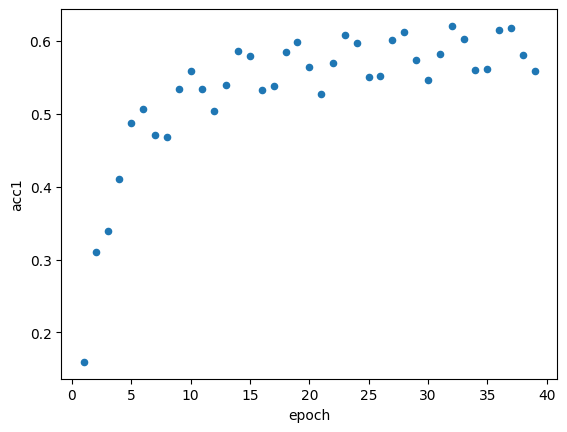

In [171]:
d.plot(x='epoch', y=metric, kind='scatter')

<Axes: >

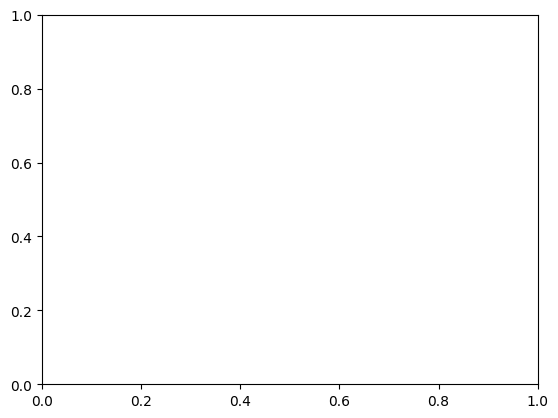

In [153]:
d = results[results.total_epochs==results.epoch].copy()
ds = 'wds/imagenet1k'
metric = 'acc1'
d = d[d.downstream_dataset==ds]
d = d[d.samples_seen_scale=="1.28M"]
sns.barplot(x="global_batch_size", y="acc1", hue="lr", data=d, estimator="max", errorbar=None)

<Axes: >

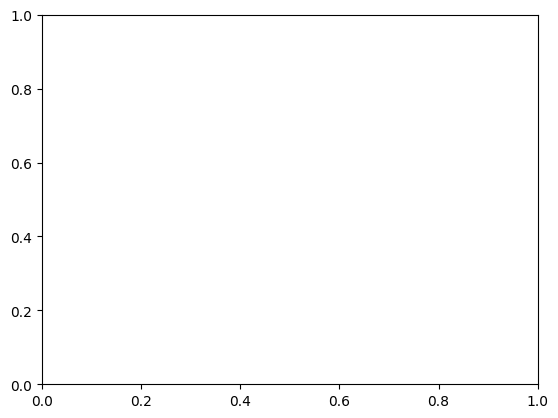

In [154]:
d = results[results.total_epochs==results.epoch].copy()
ds = 'wds/imagenet1k'
metric = 'acc1'
d = d[d.downstream_dataset==ds]
d = d[d.samples_seen_scale=="1.28M"]
sns.barplot(x="global_batch_size", y="acc1", hue="siglip", data=d, estimator="max", errorbar=None)

In [155]:
d = results[results.total_epochs==results.epoch].copy()
ds = 'wds/imagenet1k'
metric = 'acc1'
d = d[d.downstream_dataset==ds]
d = d[d.samples_seen_scale=="1.28M"]
#d = d[d.samples_seen_scale=="128M"]
d["name"] = d["name"].apply(lambda n:n.replace("sigTrue", "").replace("sigFalse", ""))
d = d.pivot(index="name", columns="siglip", values="acc1")
d = d.style.highlight_max(color='lightgreen', axis=1)
d

name


In [156]:
d = results[results.total_epochs==results.epoch]

ds = 'wds/mscoco_captions'
metric = 'image_retrieval_recall@5'

d = d[d.downstream_dataset==ds]
d[[metric] + cols].sort_values(by=metric, ascending=False).round(4)

,image_retrieval_recall@5,model,samples_seen_scale,downstream_dataset,lr,gflops_total,siglip,gpus,batch_size,global_batch_size,samples_per_sec,training_time_hours,total_steps,name
13,0.5399,ViT-B-32,2.944B,wds/mscoco_captions,0.001,4.351232e+10,False,256,354,90624,211988.9815,4.1931,35310,datacomp_ViT-B-32_ep100_lr0.001_b1_0.9_b2_0.95_wd0.2_w500_gc1_n64_bs354_sigFalse_period128000000_train
29,0.5361,ViT-B-32,2.432B,wds/mscoco_captions,0.001,3.594496e+10,False,256,354,90624,211988.9815,4.1931,35310,datacomp_ViT-B-32_ep100_lr0.001_b1_0.9_b2_0.95_wd0.2_w500_gc1_n64_bs354_sigFalse_period128000000_train
34,0.5335,ViT-B-32,3.456B,wds/mscoco_captions,0.001,5.107968e+10,False,256,354,90624,211988.9815,4.1931,35310,datacomp_ViT-B-32_ep100_lr0.001_b1_0.9_b2_0.95_wd0.2_w500_gc1_n64_bs354_sigFalse_period128000000_train
25,0.5273,ViT-B-32,3.072B,wds/mscoco_captions,0.001,4.540416e+10,False,256,354,90624,211988.9815,4.1931,35310,datacomp_ViT-B-32_ep100_lr0.001_b1_0.9_b2_0.95_wd0.2_w500_gc1_n64_bs354_sigFalse_period128000000_train
53,0.5166,ViT-B-32,2.304B,wds/mscoco_captions,0.001,3.405312e+10,False,256,354,90624,211988.9815,4.1931,35310,datacomp_ViT-B-32_ep100_lr0.001_b1_0.9_b2_0.95_wd0.2_w500_gc1_n64_bs354_sigFalse_period128000000_train
52,0.5148,ViT-B-32,1.792B,wds/mscoco_captions,0.001,2.648576e+10,False,256,354,90624,211988.9815,4.1931,35310,datacomp_ViT-B-32_ep100_lr0.001_b1_0.9_b2_0.95_wd0.2_w500_gc1_n64_bs354_sigFalse_period128000000_train
40,0.5102,ViT-B-32,1.92B,wds/mscoco_captions,0.001,2.837760e+10,False,256,354,90624,211988.9815,4.1931,35310,datacomp_ViT-B-32_ep100_lr0.001_b1_0.9_b2_0.95_wd0.2_w500_gc1_n64_bs354_sigFalse_period128000000_train
31,0.5093,ViT-B-32,2.816B,wds/mscoco_captions,0.001,4.162048e+10,False,256,354,90624,211988.9815,4.1931,35310,datacomp_ViT-B-32_ep100_lr0.001_b1_0.9_b2_0.95_wd0.2_w500_gc1_n64_bs354_sigFalse_period128000000_train
18,0.5075,ViT-B-32,2.56B,wds/mscoco_captions,0.001,3.783680e+10,False,256,354,90624,211988.9815,4.1931,35310,datacomp_ViT-B-32_ep100_lr0.001_b1_0.9_b2_0.95_wd0.2_w500_gc1_n64_bs354_sigFalse_period128000000_train
36,0.4948,ViT-B-32,3.328B,wds/mscoco_captions,0.001,4.918784e+10,False,256,354,90624,211988.9815,4.1931,35310,datacomp_ViT-B-32_ep100_lr0.001_b1_0.9_b2_0.95_wd0.2_w500_gc1_n64_bs354_sigFalse_period128000000_train


# Downstream Task Learning curves

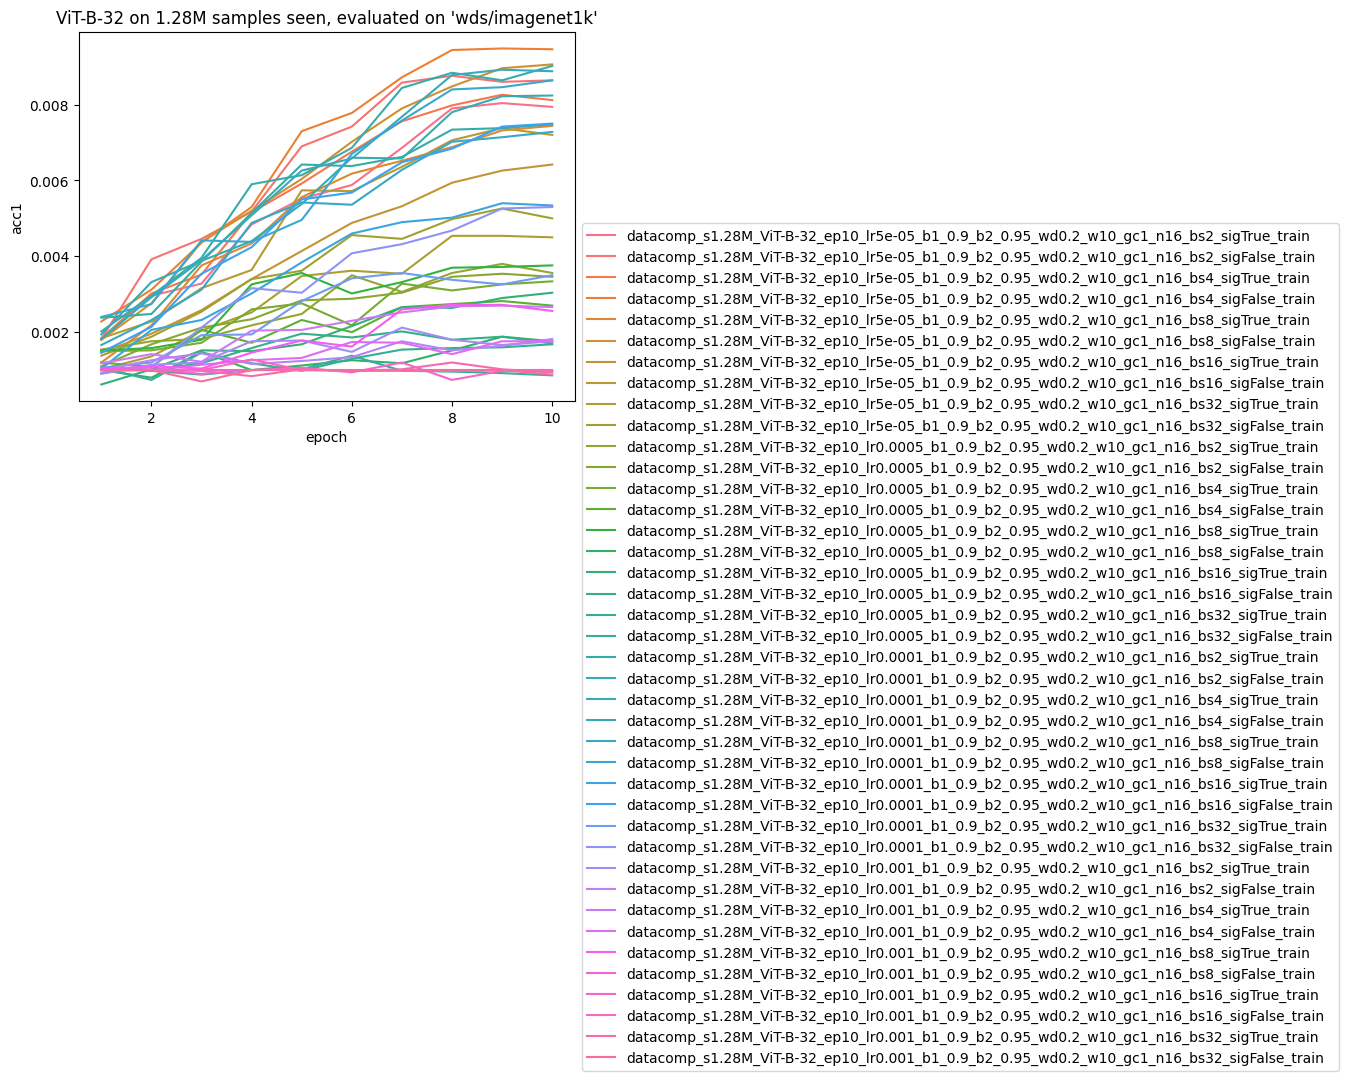

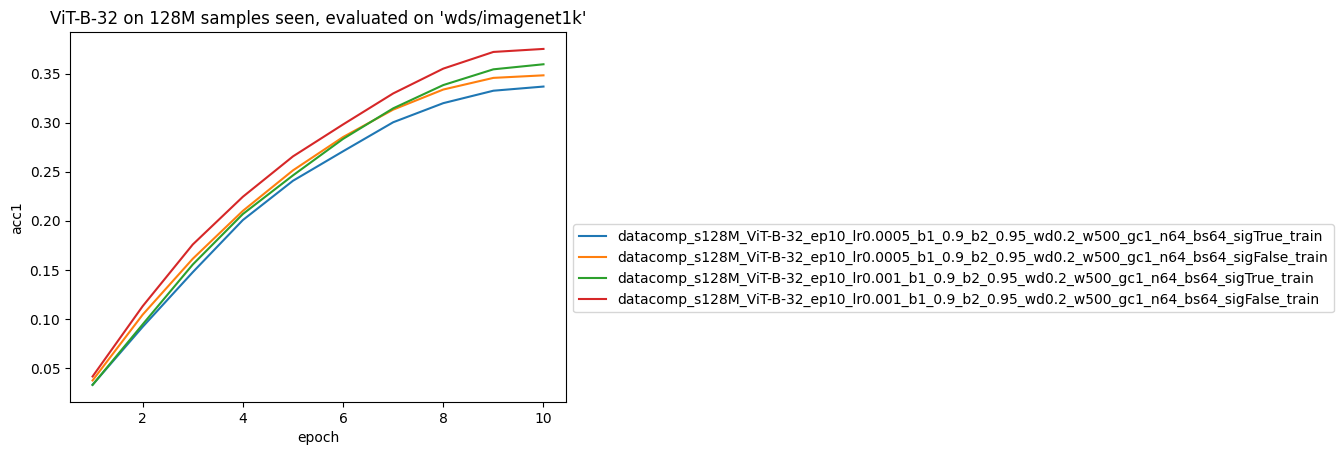

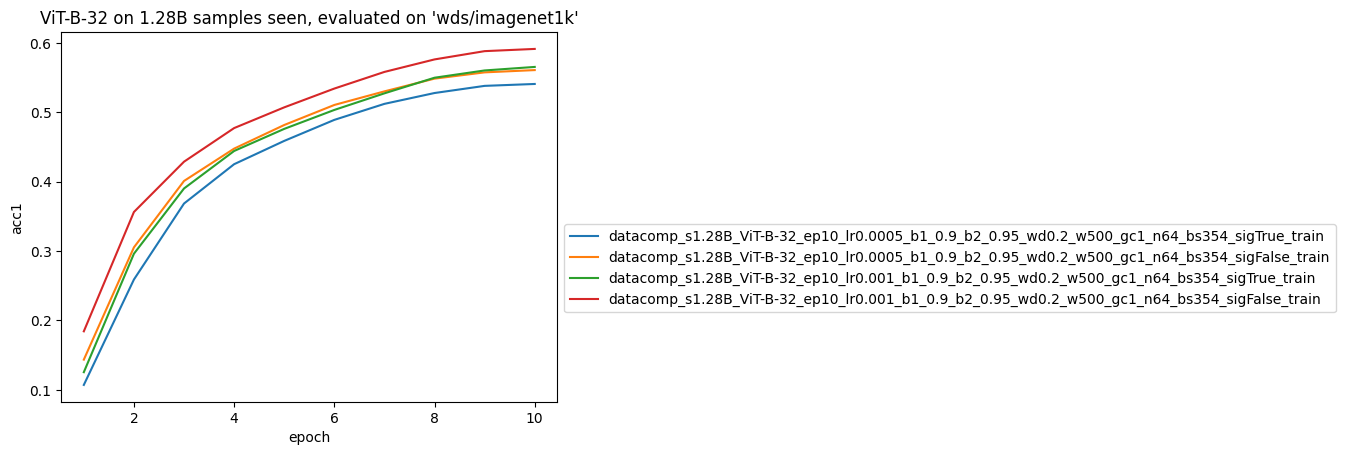

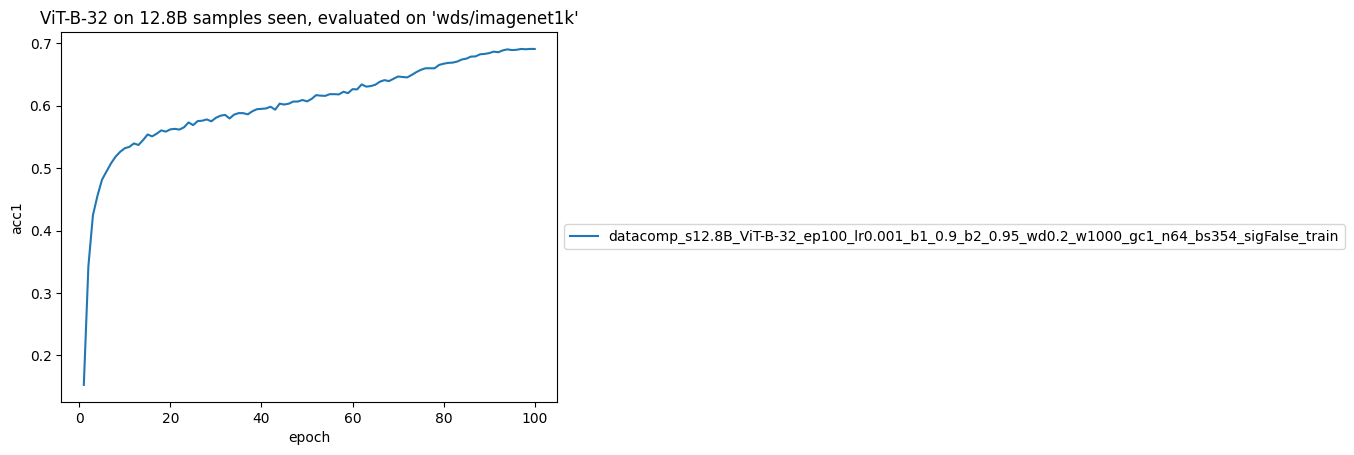

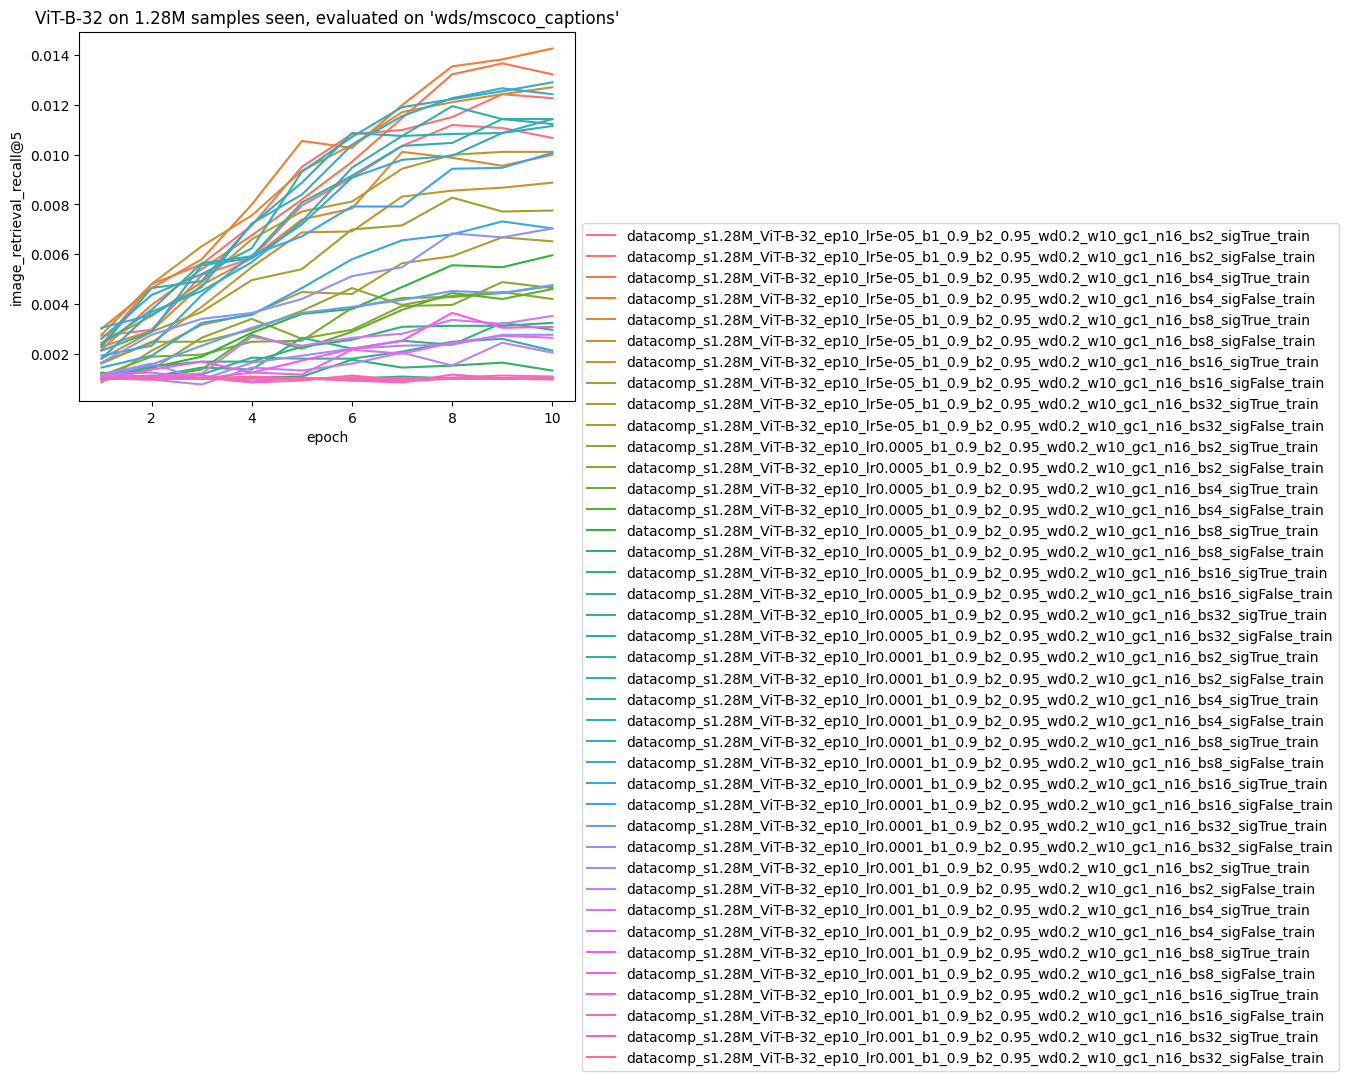

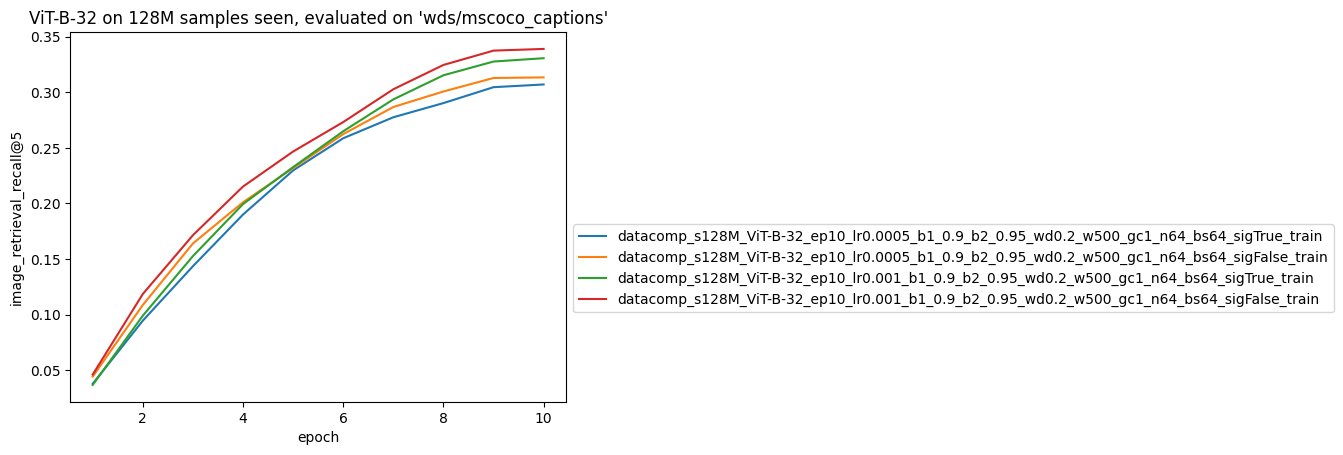

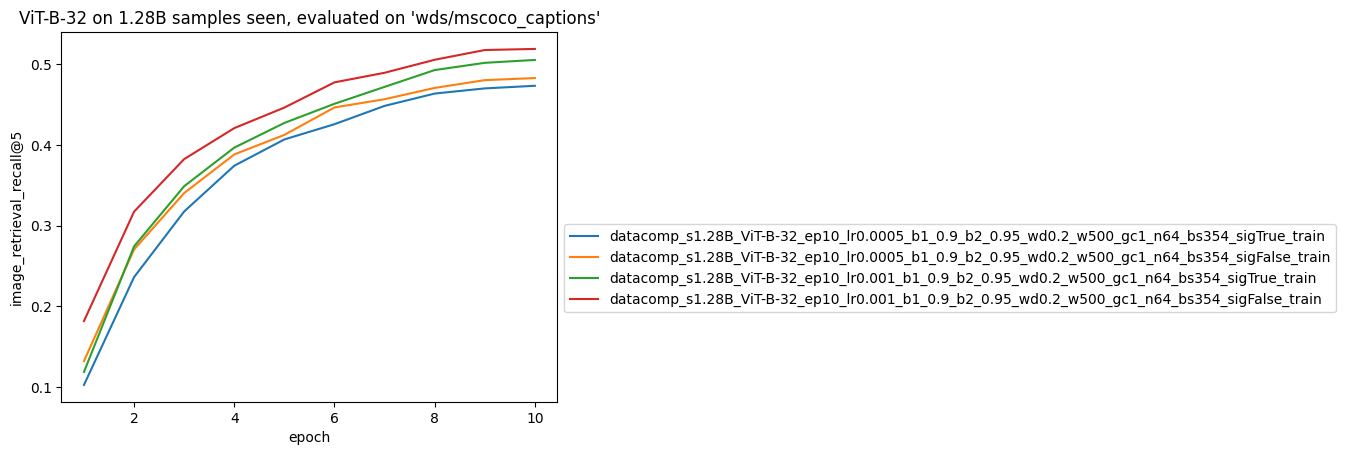

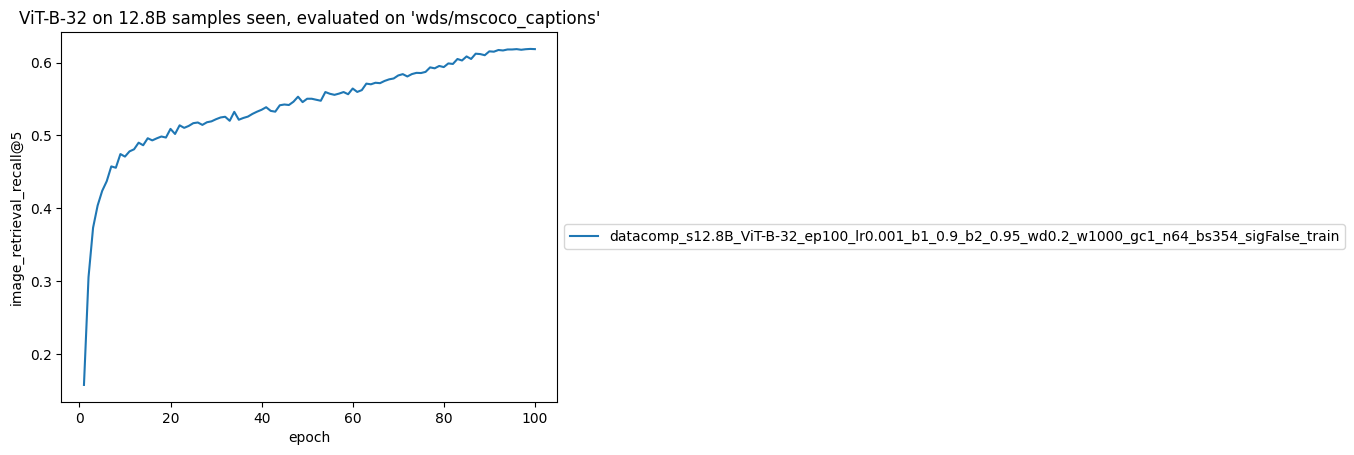

In [99]:
for model in ("ViT-B-32",):
    for (ds, metric) in ( ("wds/imagenet1k", "acc1"), ("wds/mscoco_captions", "image_retrieval_recall@5")):
        for samples_seen in ("1.28M", "128M", "1.28B", "3B", "12.8B"):
            d = results
            d = d[(d.model == model) & (d.samples_seen_scale==samples_seen) & (d.downstream_dataset==ds)]
            if not len(d):
                continue
            sns.lineplot(x="epoch", y=metric, data=d, hue="name")
            #d = d.sort_values(by='epoch')
            #d.plot(x='epoch', y=metric)
            plt.title(f"{model} on {samples_seen} samples seen, evaluated on '{ds}'")
            plt.legend(bbox_to_anchor=(1,0.5))
            plt.show()

# Scaling curve

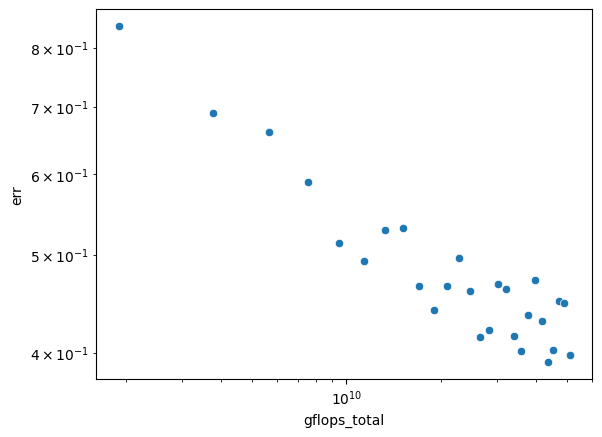

In [157]:
d = results[results.total_epochs==results.epoch]
#d = results
ds = 'wds/imagenet1k'
metric = 'acc1'
d = d[d.downstream_dataset==ds]
d["err"] = 1 - d[metric]
sns.scatterplot(x="gflops_total", y="err", data=d)
plt.xscale("log")
plt.yscale("log")

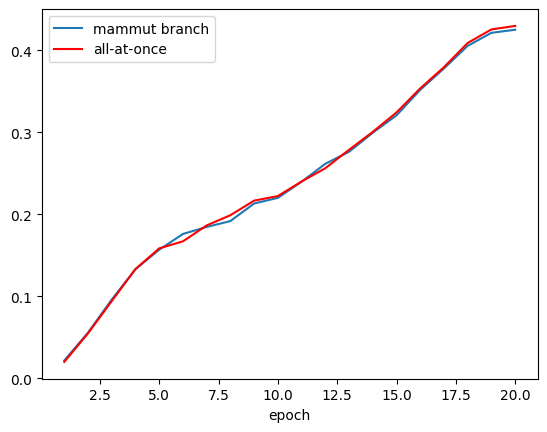

In [219]:
fig, ax = plt.subplots()
res_mammut_branch[res_mammut_branch.dataset=="imagenet1k"].plot(x="epoch", y="acc1", kind="line", ax=ax, label="mammut branch")
res_all_at_once[res_all_at_once.dataset=="imagenet1k"].plot(x="epoch", y="acc1", kind="line", ax=ax, c='red', label="all-at-once")
plt.legend()

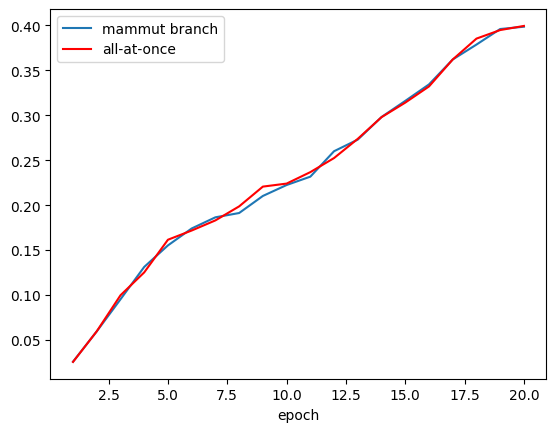

In [218]:
fig, ax = plt.subplots()
res_mammut_branch[res_mammut_branch.dataset=="mscoco"].plot(x="epoch", y="image_retrieval_recall@5", kind="line", ax=ax, label="mammut branch")
res_all_at_once[res_all_at_once.dataset=="mscoco"].plot(x="epoch", y="image_retrieval_recall@5", kind="line", ax=ax, c='red', label="all-at-once")
plt.legend()